## How to use

ALWAYS run Configurations and Related functions before proceeding.

Choose 1 out of the 2 options:
- Hit "Run All" and start from the original datasets (check configs).
- Scroll down to Main Dataset section, there is option to load pre-prepped datasets, run the codes starting from there after configurations.

For easier readability: search "VS code jupyter notebook collapse all".

In order to shorten time, use flag show_parts = True.

NOTE: In my results, the unified dataset contains 23419469 rows x 155 columns, assuming MAX 4 bytes (float) per data, is around 14.5 GB MAX. So make sure you have at least 15 GB if you intend to output the unified dataset.

## Configurations

In [1]:
dataset_input_dir = "dataset/full/"
dataset_output_dir = ""
show_parts = True

user_dataset_input = dataset_input_dir + "users-details-2023.csv"                                                                                                                                                                                                   #p@stwi2x
user_dataset_output = dataset_output_dir + "user_dataset_prep.csv"
anime_dataset_input = dataset_input_dir + "anime-dataset-2023.csv"
anime_dataset_output = dataset_output_dir + "anime_dataset_prep.csv"
unified_dataset_input = dataset_input_dir + "users-score-2023.csv"
unified_dataset_output = dataset_output_dir + "unified_dataset_prep.csv"

from pyspark.sql import SparkSession
spark = SparkSession\
    .builder \
    .appName("Spark SQL app")\
    .getOrCreate()

25/03/26 19:27:46 WARN Utils: Your hostname, p4stwi2x resolves to a loopback address: 127.0.1.1; using 192.168.100.188 instead (on interface wlp2s0)
25/03/26 19:27:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/26 19:27:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/26 19:27:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Related functions

##### Simple functions

In [2]:
def print_shape(dataFrame):
    print(dataFrame.count(), len(dataFrame.columns))
def unique_categories(dataFrame, colName, show: bool = True):
    L = dataFrame.select(colName).rdd.flatMap(lambda x: x).collect()
    valueSet = {}
    for i in L:
        if i is not None:
            temp = i.split(", ")
            for j in temp:
                if colName + "_" + j not in valueSet.keys():
                    valueSet.update({colName + "_" + j: 1})
                else:
                    valueSet[colName + "_" + j] += 1
    if show:
        print(valueSet)
    return valueSet

##### One-hot encoding

In [3]:
# cre: https://stackoverflow.com/questions/62408093/one-hot-encoding-multiple-categorical-data-in-a-column
import gc
def oneHotEncoding(dataFrame, colName: str, show: bool = True, support: int = 0):
    size_before = dataFrame.count()

    test_df = dataFrame.select(colName)
    if show:
        print(f"Fill rate: {test_df.filter(col(colName).isNotNull()).count()}/{test_df.count()}")

    # collect list of unique genres
    valueSet = unique_categories(test_df, colName, show=False)
    # support
    for i in valueSet.copy():
        if valueSet[i] < support:
            valueSet.pop(i, None)

    # transfer unique values to panda DF to map the entries
    test_df_pd = test_df.dropDuplicates().toPandas()
    test_df_pd = test_df_pd.reindex(test_df_pd.columns.tolist() + list(valueSet), axis=1, fill_value=0)
    input_list = test_df_pd[colName].tolist()
    for i in range(len(input_list)):
        if input_list[i] is not None:
            temp = input_list[i].split(", ")
            for j in temp:
                if j is not None and colName + "_" + j in valueSet.keys():
                    test_df_pd.at[i, colName + "_" + j] = 1
    test_df = spark.createDataFrame(test_df_pd)
    if show:
        test_df.show()

    dataFrame = dataFrame.join(test_df, colName, "left").drop(colName) #hmmmm
    if show:
        dataFrame.show()
    # print(f"Size before: {size_before}")
    # print(f"Size after: {user_df.count()}")

    # store the embedding column list
    embed_column_list = list(valueSet.keys())

    # clean up mem
    del [[test_df_pd]]
    gc.collect()

    return dataFrame, embed_column_list


#### Normalization

Min max

In [4]:
from pyspark.sql.functions import min, max, col
def min_max(dataFrame, colName_in: str, colName_out: str):
    temp_df = dataFrame.select(min(colName_in), max(colName_in)).collect()
    min_val, max_val = float(temp_df[0][0]), float(temp_df[0][1])

    dataFrame = dataFrame.withColumn(colName_out, (col(colName_in)-min_val)/(max_val-min_val))                                                                                                                                                                                         #thien7170

    return dataFrame, list([min_val, max_val])

##### Plot

In [5]:
from pyspark.sql.functions import min, max
import pandas as pd

def plot(dataFrame, colName: str):
    gre_histogram = dataFrame.select(colName).filter(col(colName).cast("float").isNotNull())\
        .rdd.flatMap(lambda x: x)\
        .map(float)\
        .histogram(20)

    pd.DataFrame(
        list(zip(*gre_histogram)), 
        columns=['bin', 'frequency']
    ).set_index('bin').plot(kind='bar')

## User dataset

### Dataset

In [6]:
user_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(user_dataset_input)

user_embed_columns = {}

# element: UNKNOWN
user_df = user_df.replace({'UNKNOWN': None, 'Unknown': None})
user_df.dropDuplicates()

if show_parts:
    start_X, start_Y = user_df.count(), len(user_df.columns)
    print_shape(user_df)
    user_df.show(20)

25/03/26 19:28:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


731290 16
+------+---------------+------+--------------------+--------------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|Mal ID|       Username|Gender|            Birthday|            Location|              Joined|Days Watched|Mean Score|Watching|Completed|On Hold|Dropped|Plan to Watch|Total Entries|Rewatched|Episodes Watched|
+------+---------------+------+--------------------+--------------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|     1|          Xinil|  Male|1985-03-04T00:00:...|          California|2004-11-05T00:00:...|       142.3|      7.37|     1.0|    233.0|    8.0|   93.0|         64.0|        399.0|     60.0|          8458.0|
|     3|        Aokaado|  Male|                NULL|        Oslo, Norway|2004-11-11T00:00:...|        68.6|      7.34|    23.0|    137.0|   99.0|   44.0| 

In [7]:
# check sparsity for each column
from pyspark.sql.functions import col
from collections import OrderedDict

if show_parts:
    rows = user_df.count()
    sparsity_score = [user_df.filter(col(Col).isNotNull()).count() / rows for Col in user_df.columns]

    sparsity_list = OrderedDict()
    for i in range(len(user_df.columns)):
        sparsity_list[user_df.columns[i]] = sparsity_score[i]
    #spark.createDataFrame([d_list]).show()
    print(sparsity_list.items())

odict_items([('Mal ID', 1.0), ('Username', 0.999998632553433), ('Gender', 0.30683176304885884), ('Birthday', 0.22982400962682384), ('Location', 0.208885667792531), ('Joined', 1.0), ('Days Watched', 0.9999890604274638), ('Mean Score', 0.9999890604274638), ('Watching', 0.9999890604274638), ('Completed', 0.9999890604274638), ('On Hold', 0.9999890604274638), ('Dropped', 0.9999890604274638), ('Plan to Watch', 0.9999890604274638), ('Total Entries', 0.9999890604274638), ('Rewatched', 0.9999890604274638), ('Episodes Watched', 0.9999890604274638)])


### Data preprocessing

#### Username

This column is just user's username as strings, should be dropped to make the dataset lighter and we already have Mal ID as user index.

In [8]:
user_df = user_df.drop('Username')

#### Gender

As this categorical column has 2 values at most, we perform one-hot encoding.

In [9]:
user_df, col_list = oneHotEncoding(user_df, 'Gender', show=show_parts)
user_embed_columns['Gender'] = col_list

Fill rate: 224383/731290


+----------+-----------+-------------+-----------------+
|    Gender|Gender_Male|Gender_Female|Gender_Non-Binary|
+----------+-----------+-------------+-----------------+
|    Female|          0|            1|                0|
|Non-Binary|          0|            0|                1|
|      Male|          1|            0|                0|
|      NULL|          0|            0|                0|
+----------+-----------+-------------+-----------------+



+------+--------------------+--------------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+-----------+-------------+-----------------+
|Mal ID|            Birthday|            Location|              Joined|Days Watched|Mean Score|Watching|Completed|On Hold|Dropped|Plan to Watch|Total Entries|Rewatched|Episodes Watched|Gender_Male|Gender_Female|Gender_Non-Binary|
+------+--------------------+--------------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+-----------+-------------+-----------------+
|     9|                NULL|                NULL|2004-12-05T00:00:...|        30.0|      7.71|     5.0|     54.0|    4.0|    3.0|          0.0|         66.0|      0.0|          1817.0|       NULL|         NULL|             NULL|
|    18|                NULL|                NULL|2005-01-03T00:00:...|        5

#### Birthday

We shall convert the non-null values to unix timestamps.

In [10]:
from pyspark.sql.functions import split, unix_timestamp
split_col = split(user_df['Birthday'], 'T', 2)
user_df = user_df.withColumn('Birthday_d', split_col.getItem(0))\
    .withColumn('Birthday_unix', unix_timestamp('Birthday_d', format='yyyy-mm-dd'))\
    .drop('Birthday', 'Birthday_d')\
    .withColumnRenamed('Birthday_unix', 'Birthday')

In [11]:
if show_parts:
    user_df.select('Birthday').where('Birthday is not NULL').show(5)

+---------+
| Birthday|
+---------+
|569782920|
|664650600|
|473619780|
|570042060|
|631818120|
+---------+
only showing top 5 rows



It is worth noting that anime titles are vastly different for users of different ages, that is why we shall perform user age when giving rating.

However, for the time being, we shall perform a simple plotting and eliminating outliers.

In [12]:
user_df, _ = min_max(user_df, 'Birthday', 'Birthday_m')
user_df = user_df.drop('Birthday')\
    .withColumnRenamed('Birthday_m', 'Birthday')

731290 17


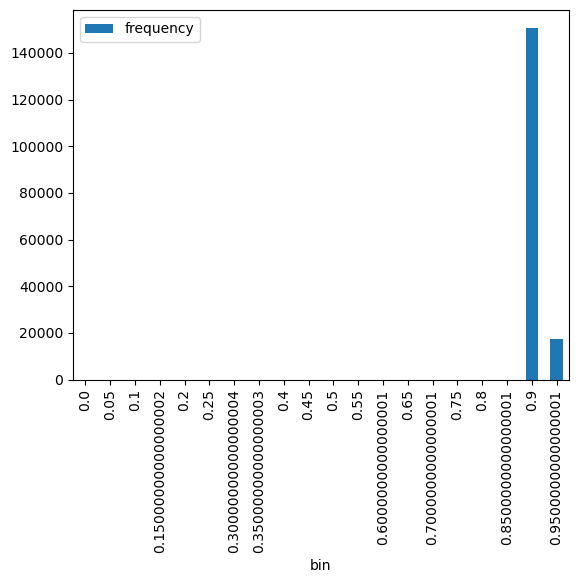

In [13]:
if show_parts:
    print_shape(user_df)
    plot(user_df, 'Birthday')

731275 17


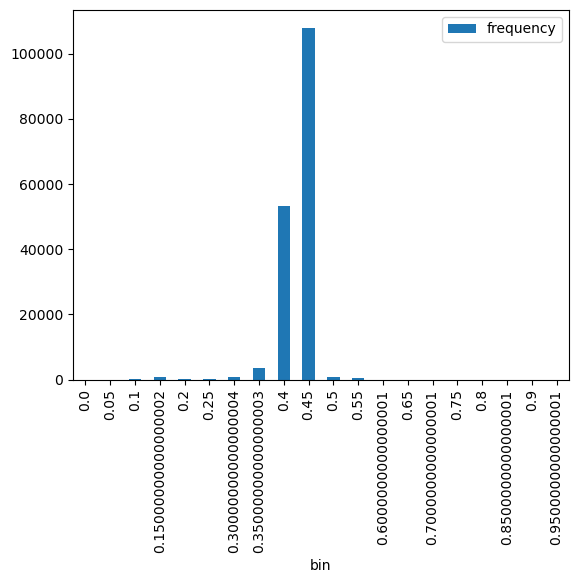

In [14]:
user_df = user_df.filter('Birthday is NULL OR Birthday >= 0.9')
user_df, _ = min_max(user_df, 'Birthday', 'Birthday_m')
user_df = user_df.drop('Birthday')\
    .withColumnRenamed('Birthday_m', 'Birthday')
if show_parts:
    print_shape(user_df)
    plot(user_df, 'Birthday')

724456 17


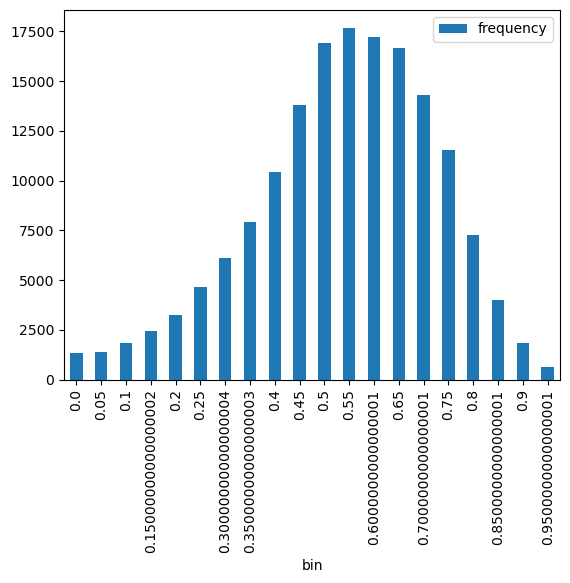

In [15]:
user_df = user_df.filter('Birthday is NULL OR (Birthday >= 0.4 AND Birthday < 0.5)')
user_df, user_embed_columns['Birthday'] = min_max(user_df, 'Birthday', 'Birthday_m')
user_df = user_df.drop('Birthday')\
    .withColumnRenamed('Birthday_m', 'Birthday')
if show_parts:
    print_shape(user_df)
    plot(user_df, 'Birthday')

Examining the skewness of the observed data:

In [16]:
from pyspark.sql.functions import mean, median
if show_parts:
    user_df.select(mean('Birthday'), median('Birthday')).show()

+------------------+------------------+
|     avg(Birthday)|  median(Birthday)|
+------------------+------------------+
|0.5519932547907472|0.5524984815873584|
+------------------+------------------+



As the metrics are very close to each other, the skewness of the observed data should not be a concern for us.

In [17]:
if show_parts:
    print_shape(user_df)

724456 17


#### Location (finished)

In [18]:
if show_parts:
    user_df.select('Location').where('Location is not NULL').show()

+--------------------+
|            Location|
+--------------------+
|              Canada|
|Melbourne, Australia|
|              Canada|
|                 UAE|
|          California|
|        Oslo, Norway|
|      Bergen, Norway|
|Land of Rain and ...|
|31f288172a11dea9f...|
|         Calgary, AB|
|       Paris, France|
| Seattle, Washington|
|              Latvia|
|     good ol' Europe|
|      London,England|
| Lule&aring;, Sweden|
|     Ontario, Canada|
|Locked up in Shuu...|
|    Tampere, Finland|
|       Finland, Pori|
+--------------------+
only showing top 20 rows



As you can see, the location format is very inconsistent, going back and forth between cities and/or countries and imcomprehensible values. 

It is better for us to drop this column for now.

In [19]:
user_df = user_df.drop('Location')

#### Joined (finished)

This is the date when the user joins the MyAnimeList platform. If we intend to use this data to check user's anime-watching duration to give more weights to those who watch more and are able to rate titles more objectively, it shall be better to use the column "Days Watched" instead.

Hence, this column is dropped.

In [20]:
user_df = user_df.drop('Joined')

#### Days Watched (finished)

This column shows the number of days user has spent watching anime. The more experience one has with watching, one could judge and rate anime titles more accurately.

Hence, we use this column, with the name changed for easier SQL queries.

In [21]:
user_df = user_df.withColumnRenamed('Days Watched', 'Days_Watched')

The more time one spends watching anime, the more they can observe and rate anime titles more correctly. And the difference between experienced watchers (such as 1000 and 2000 hours) is not as much as between inexperienced (10 hours) and experienced (500 hours).

We shall perform log transformation then standardization and do not perform any outlier elimination.

In [22]:
from pyspark.sql.functions import log10, col
user_df = user_df.withColumn('Days_Watched_log', log10(col('Days_Watched')+1.0))
user_df = user_df.drop('Days_Watched')\
.withColumnRenamed('Days_Watched_log', 'Days_Watched')

user_df, user_embed_columns['Days_Watched'] = min_max(user_df, 'Days_Watched', 'A1')
user_df = user_df.drop('Days_Watched').withColumnRenamed('A1', 'Days_Watched')

if show_parts:
    user_df.select('Days_Watched').show(5)

+-------------------+
|       Days_Watched|
+-------------------+
| 0.2969307069606323|
| 0.3433040120799939|
|0.46390546083098444|
|0.42930947492004035|
| 0.3668642331580207|
+-------------------+
only showing top 5 rows



In [23]:
if show_parts:
    print_shape(user_df)

724456 15


#### Mean Score (finished)

This column is mean to see how user rates compared to how they usually rate, so it shall be left untouched until joining the datasets into one unified file.

#### Watching, On Hold, Dropped, Plan to Watch, Total Entries (finished)

These columns are to see how the user interacts with anime titles.

However, to us, these columns do not mean a lot about user's rating sincerity as we are recommending anime based on tastes.

In [24]:
user_df = user_df.drop('Watching', 'On Hold', 'Dropped', 'Plan to Watch', 'Total Entries')

#### Completed, Rewatched, Episodes Watched (finished)

These columns are important in determining user's experience in watching anime, similar to Days Watched. However, since Rewatched only counts number of titles a user has rewatched, without pointing out which titles exactly, and furthermore is similar to, and counted within, the Episodes Watched column.

Our decision is to drop Rewatched, and keep the other two, like Days Watched: log transformation.

In [25]:
user_df = user_df.drop('Rewatched')\
    .withColumnRenamed('Episodes Watched', 'Episodes_Watched')

a, b = 'Episodes_Watched', 'Completed'

user_df = user_df.withColumn(a + '_l', log10(col(a)+1.0))\
    .withColumn(b+ '_l', log10(col(b)+1.0))\
    .drop(a, b)\
    .withColumnRenamed(a+'_l', a)\
    .withColumnRenamed(b+'_l', b)

user_df, user_embed_columns[b] = min_max(user_df, b, b+'_m')
user_df, user_embed_columns[a] = min_max(user_df, a, a+'_m')
user_df = user_df.drop(a,b)\
    .withColumnRenamed(a+'_m', a)\
    .withColumnRenamed(b+'_m', b)

if show_parts:
    user_df.select(a,b).show(5)

+-------------------+-------------------+
|   Episodes_Watched|          Completed|
+-------------------+-------------------+
|0.43296957900693545|0.42226835100537496|
| 0.4626086871667314|  0.499992032821234|
| 0.5454766530346725| 0.6803750397714515|
| 0.5216630439384277| 0.5748484952726145|
| 0.4795024105641635| 0.5192039674374592|
+-------------------+-------------------+
only showing top 5 rows



In [26]:
if show_parts:
    print_shape(user_df)

724456 9


### Final results

In [27]:
if show_parts:
    print("Before: " + str(start_X) + " " + str(start_Y))
    print("After: ", end = '')
    print_shape(user_df)
    user_df.show()

Before: 731290 16
After: 

724456 9


+------+----------+-----------+-------------+-----------------+-------------------+-------------------+-------------------+-------------------+
|Mal ID|Mean Score|Gender_Male|Gender_Female|Gender_Non-Binary|           Birthday|       Days_Watched|          Completed|   Episodes_Watched|
+------+----------+-----------+-------------+-----------------+-------------------+-------------------+-------------------+-------------------+
|     9|      7.71|       NULL|         NULL|             NULL|               NULL| 0.2969307069606323|0.42226835100537496|0.43296957900693545|
|    18|      6.27|       NULL|         NULL|             NULL|               NULL| 0.3433040120799939|  0.499992032821234| 0.4626086871667314|
|    23|      7.41|       NULL|         NULL|             NULL|0.40191615168022443| 0.4294300721561046| 0.6006780061626525| 0.5223881650875452|
|    53|      9.24|       NULL|         NULL|             NULL|               NULL| 0.2183952202750305| 0.4163579848100237|0.37741579455

### Saving data

Preprocessed dataset

In [28]:
user_df.coalesce(1).write\
        .option("header", "true")\
        .option("sep", ",")\
        .mode("overwrite")\
        .csv(user_dataset_output)

Embedded columns

In [29]:
import json

with open('user_embed_col.json', 'w') as fp:
    json.dump(user_embed_columns, fp, indent=4)

## Anime dataset

### Dataset

In [30]:
anime_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(anime_dataset_input)

anime_embed_columns = {}

# element: UNKNOWN
anime_df = anime_df.replace({'UNKNOWN': None, 'Unknown': None})
anime_df.dropDuplicates()

# change column names for better SQL
anime_df = anime_df.withColumnRenamed('Scored By', 'Scored_By')

if show_parts:
    start_X, start_Y = anime_df.count(), len(anime_df.columns)
    print_shape(anime_df)
    anime_df.show(20)

24905 24
+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|anime_id|                Name|        English name|                    Other name|Score|              Genres|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|
+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+-------------

In [31]:
# check sparsity for each column
from pyspark.sql.functions import col
from collections import OrderedDict

if show_parts:
    rows = anime_df.count()
    sparsity_score = [anime_df.filter(col(Col).isNotNull()).count() / rows for Col in anime_df.columns]

    sparsity_list = OrderedDict()
    for i in range(len(anime_df.columns)):
        sparsity_list[anime_df.columns[i]] = sparsity_score[i]
    #spark.createDataFrame([d_list]).show()
    sparsity_list.items()

### Data preprocessing

#### Name, English name, Other name (finished)

Since the problem is about recommendation based on user's taste, it is expected that these features have nothing to do with our recommendation system.

In [32]:
anime_df = anime_df.drop("Name", "English name", "Other name")
if show_parts:
    anime_df.show()

+--------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|anime_id|Score|              Genres|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|
+--------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|       1| 8.75|Action, Award Win...|Crime is timeless...|   TV|    26.0|Apr 3, 1998 to Ap...|spring 1998| Fi

In [33]:
print_shape(anime_df)

24905 21


#### Score (finished)

As this is a numerical column, we perform data normalization.

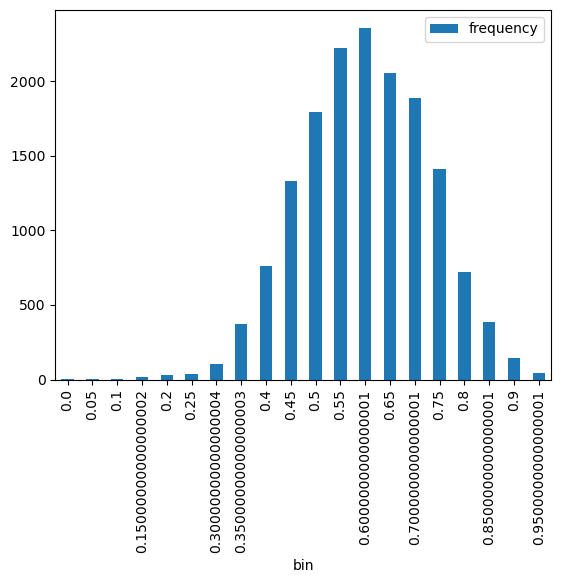

In [34]:
anime_df, anime_embed_columns['Score'] = min_max(anime_df, "Score", "Score_s")

anime_df = anime_df.drop('Score').withColumnRenamed(existing="Score_s",new="Score")

if show_parts:
    plot(anime_df, "Score")

In [35]:
if show_parts:
    anime_df.select("Score").show()

+------------------+
|             Score|
+------------------+
|0.9517241379310345|
| 0.900689655172414|
|0.8786206896551726|
|0.7448275862068966|
|0.7020689655172414|
|0.8372413793103448|
|0.8482758620689655|
| 0.786206896551724|
| 0.870344827586207|
|0.9682758620689654|
| 0.846896551724138|
|0.9434482758620689|
|0.8289655172413792|
| 0.626206896551724|
|0.8331034482758619|
| 0.762758620689655|
|0.8151724137931035|
|0.7503448275862068|
|0.8358620689655173|
|0.7765517241379312|
+------------------+
only showing top 20 rows



In [36]:
from pyspark.sql.functions import median, mode
if show_parts:
    anime_df.select(median("Score"), mode("Score")).show()

+-----------------+------------------+
|    median(Score)|       mode(Score)|
+-----------------+------------------+
|0.626206896551724|0.6151724137931033|
+-----------------+------------------+



Even though the data is negatively skewed (mean = 0, median = 0.009, mode = 0.171), the skewed-ness is insignificant and can be allowed for analysis.

In [37]:
if show_parts:
    print_shape(anime_df)

24905 21


#### Genres (finished)

Since the column is categorical and the label order in Genres is not important, we use one-hot encoding.

In [38]:
anime_df, col_list = oneHotEncoding(anime_df, "Genres", show=show_parts)
anime_embed_columns['Genres'] = col_list

Fill rate: 19976/24905


+--------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+
|              Genres|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_Drama|Genres_Mystery|Genres_Supernatural|Genres_Fantasy|Genres_Sports|Genres_Comedy|Genres_Romance|Genres_Slice of Life|Genres_Suspense|Genres_Ecchi|Genres_Gourmet|Genres_Avant Garde|Genres_Horror|Genres_Girls Love|Genres_Boys Love|Genres_Hentai|Genres_Erotica|
+--------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+--------

25/03/26 19:31:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+--------------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+
|anime_id|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|             Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|             Score|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_Drama|Ge

In [39]:
if show_parts:
    print_shape(anime_df)

24905 41


#### Synopsis (finished)

Synopsis is description of an anime title and has quite some impact to user's taste. However we temporarily leave this out for simplicity.

In [40]:
anime_df = anime_df.drop("Synopsis")

#### Type (finished)

Similar to Genres, we use one-hot encoding here.

In [41]:
if show_parts:
    anime_df.select("Type").groupBy("Type").count().show()

+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 7597|
|   NULL|   74|
|Special| 2558|
|    OVA| 4076|
|  Music| 2686|
|  Movie| 4381|
|    ONA| 3533|
+-------+-----+



Since only 0.3% of samples have empty values, so we should have no problem dropping these rows.

In [42]:
anime_df = anime_df.filter("Type is not NULL")
anime_df.select("Type").groupBy("Type").count().show()

+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 7597|
|Special| 2558|
|    OVA| 4076|
|  Music| 2686|
|  Movie| 4381|
|    ONA| 3533|
+-------+-----+



Then we perform one-hot encoding

In [43]:
anime_df, col_list = oneHotEncoding(anime_df, "Type")
user_embed_columns['Type'] = col_list

Fill rate: 24831/24831


+-------+-------+--------+------------+----------+--------+----------+
|   Type|Type_TV|Type_OVA|Type_Special|Type_Movie|Type_ONA|Type_Music|
+-------+-------+--------+------------+----------+--------+----------+
|     TV|      1|       0|           0|         0|       0|         0|
|Special|      0|       0|           1|         0|       0|         0|
|    OVA|      0|       1|           0|         0|       0|         0|
|  Music|      0|       0|           0|         0|       0|         1|
|  Movie|      0|       0|           0|         1|       0|         0|
|    ONA|      0|       0|           0|         0|       1|         0|
+-------+-------+--------+------------+----------+--------+----------+



+--------+--------+--------------------+-----------+----------------+--------------------+--------------------+--------------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+
|anime_id|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|             Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|             Score|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_D

In [44]:
print_shape(anime_df)

24831 45


#### Episodes (finished)

Anime length (no. of episodes and duration) might have to do with watching trends.

In [45]:
anime_df, anime_embed_columns['Episodes'] = min_max(anime_df, "Episodes", "A1")
anime_df = anime_df.drop('Episodes').withColumnRenamed("A1", "Episodes")

#### Aired (finished)

The format is in the form of "(start date) to (end date)", so we perform splitting into two columns.

In [46]:
# column: Aired 
from pyspark.sql.functions import split, to_date

split_col = split(anime_df["Aired"], " to ", 2)
anime_df = anime_df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
anime_df = anime_df.withColumn("air_start", to_date(col("F1"), "MMM d, yyyy"))\
    .withColumn("air_end", to_date(col("F2"), "MMM d, yyyy"))\
    .drop("F1", "F2", "Aired")
if show_parts:
    anime_df.select("air_start", "air_end").show()

+----------+----------+
| air_start|   air_end|
+----------+----------+
|2004-10-06|2005-03-30|
|2002-10-03|2007-02-08|
|1999-10-20|      NULL|
|1998-04-01|1998-09-30|
|1995-10-04|1996-03-27|
|1998-04-03|1999-04-24|
|2004-04-17|2006-02-18|
|2002-07-03|2002-12-25|
|2003-04-17|2003-09-25|
|2004-10-08|2005-04-01|
|2004-10-06|2004-12-15|
|2005-04-29|2005-10-28|
|2004-09-30|2005-09-29|
|2005-04-15|2005-09-27|
|2004-10-12|2006-03-14|
|2004-10-05|2005-03-29|
|2002-09-11|2003-09-10|
|2004-04-07|2005-09-28|
|2005-04-06|2008-03-19|
|2001-10-10|2005-03-23|
+----------+----------+
only showing top 20 rows



In some cases, some titles do not have both timestamps.

In [47]:
if show_parts:
    print(anime_df.select("air_start", "air_end").where("air_start is not NULL").count())
    print(anime_df.select("air_start", "air_end").where("air_end is not NULL").count())
    print(anime_df.select("air_start", "air_end").where("air_start is not NULL AND air_end is not NULL").count())                                                               #p4stwi2x
    print(anime_df.count())

20088


9337


9317


24831


Since the number of missing values is huge for both columns and users can manually filter the recommendation rankings, our choice is to drop the columns in processing.

In [48]:
anime_df = anime_df.drop("air_start", "air_end")
if show_parts:
    anime_df.show()

+--------+-----------+----------------+--------------------+--------------------+--------------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+-------------------+
|anime_id|  Premiered|          Status|           Producers|           Licensors|             Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|             Score|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_Drama|Genres_Mystery|Genres_Supernatural|

#### Premiered (finished)

Since some users might have the tendency to watch the latest titles, and so as some for the older titles for nostalgia, trendy eras, etc., we shall use this feature. The feature is in the form of season and year, which we shall transform into real numbers.

Column sparsity: 0.2210801043967075


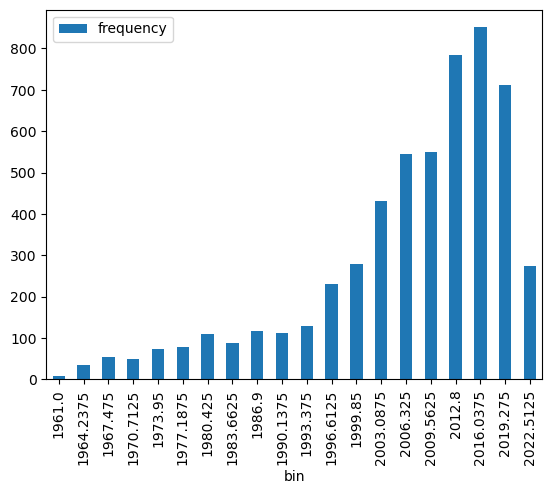

In [49]:
from pyspark.sql.functions import split, col

if show_parts:
    print(f"Column sparsity: {sparsity_list["Premiered"]}")

split_col = split(anime_df["Premiered"], " ", 2)
anime_df = anime_df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
anime_df = anime_df.na.replace(['spring', 'summer', 'fall', 'winter'], ['0', '0.25', '0.5', '0.75'], 'F1')\
    .withColumn("Premiered_f", col('F1')+col('F2')).drop("Premiered", "F1", "F2")

if show_parts:
    plot(anime_df, "Premiered_f")

+--------------------+------------------+
|median(Premiered_fo)|mode(Premiered_fo)|
+--------------------+------------------+
|  0.7876447876447876|0.8648648648648649|
+--------------------+------------------+



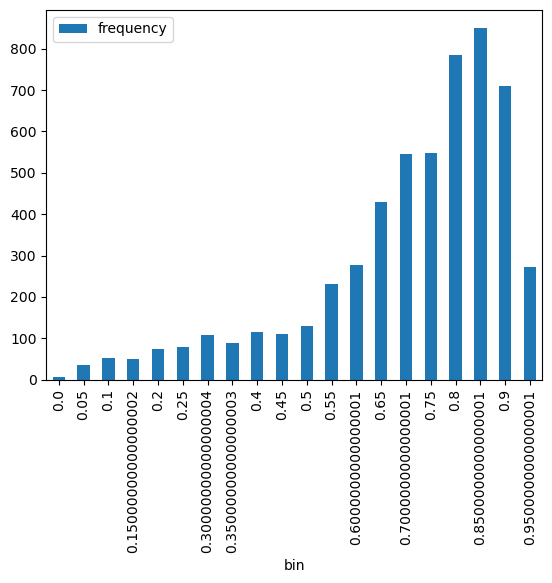

In [50]:
from pyspark.sql.functions import mean, median, mode
anime_df, anime_embed_columns['Premiered'] = min_max(anime_df, "Premiered_f", "Premiered_fo")

if show_parts:
    anime_df.select(median("Premiered_fo"), mode("Premiered_fo")).show()

anime_df = anime_df.drop("Premiered", "Premiered_f").withColumnRenamed(existing="Premiered_fo", new="Premiered")
if show_parts:
    plot(anime_df, "Premiered")

#### Status (finished)

List of unique values:

In [51]:
unique_categories(anime_df, "Status", show=show_parts)

{'Status_Finished Airing': 24063, 'Status_Currently Airing': 347, 'Status_Not yet aired': 421}


{'Status_Finished Airing': 24063,
 'Status_Currently Airing': 347,
 'Status_Not yet aired': 421}

Since the list is short, we shall perform one-hot encoding with no support without any issue.

In [52]:
anime_df, col_list = oneHotEncoding(anime_df, "Status", show=show_parts)
anime_embed_columns['Status'] = col_list
if show_parts:
    anime_df.show()

Fill rate: 24831/24831


+----------------+----------------------+-----------------------+--------------------+
|          Status|Status_Finished Airing|Status_Currently Airing|Status_Not yet aired|
+----------------+----------------------+-----------------------+--------------------+
|Currently Airing|                     0|                      1|                   0|
|   Not yet aired|                     0|                      0|                   1|
| Finished Airing|                     1|                      0|                   0|
+----------------+----------------------+-----------------------+--------------------+



+--------+--------------------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+
|anime_id|           Producers|           Licensors|             Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|              Score|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_Drama|G

+--------+--------------------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+
|anime_id|           Producers|           Licensors|             Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|              Score|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_Drama|G

#### Producers (finished)

In [53]:
uVal = unique_categories(anime_df, "Producers", show=show_parts)
if show_parts:
    print(uVal)

{'Producers_Fuji TV': 372, 'Producers_TAP': 4, 'Producers_Shueisha': 306, 'Producers_Twin Engine': 26, 'Producers_Tencent Penguin Pictures': 176, 'Producers_China Literature Limited': 37, 'Producers_Wanda Media': 2, 'Producers_Xiaoming Taiji': 1, 'Producers_iQIYI': 51, 'Producers_Xuanshi Tangmen': 6, 'Producers_Tianshi Wenhua': 2, 'Producers_Liu Cong Animation': 3, 'Producers_TMS Entertainment': 45, 'Producers_Tokyo MX': 174, 'Producers_BS11': 134, 'Producers_Kadokawa': 334, 'Producers_CTW': 7, 'Producers_Youku': 39, 'Producers_Ranzai Studio': 1, 'Producers_bilibili': 192, 'Producers_WOWOW': 65, 'Producers_Bushiroad': 123, 'Producers_BS Fuji': 82, 'Producers_Nippon Television Network': 154, 'Producers_Yomiuri TV Enterprise': 52, 'Producers_TO Books': 7, 'Producers_NetEase': 20, 'Producers_MediaNet Pictures': 7, 'Producers_Bandai Namco Music Live': 23, 'Producers_TV Tokyo': 573, 'Producers_Dentsu': 370, 'Producers_Pony Canyon': 387, 'Producers_Kodansha': 308, 'Producers_Ultra Super Pict

Too many columns so we have to add support. Firstly we have to plot the frequencies of the categories.

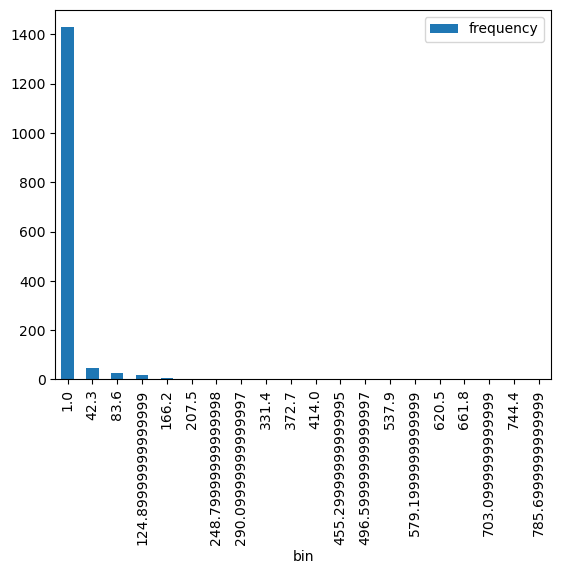

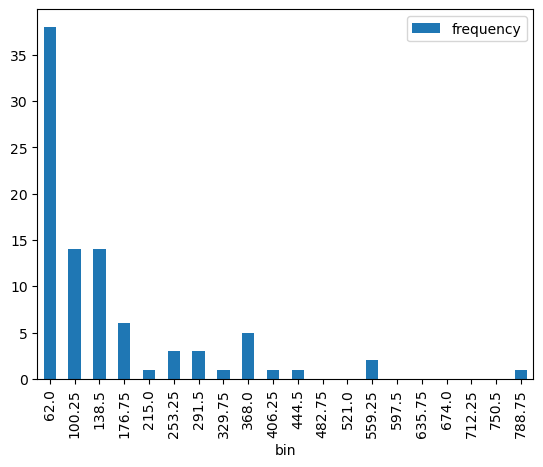

In [54]:
if show_parts:
    uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
    plot(uVal_df, "col1")
    plot(uVal_df.where("col1 > 60"), "col1")

In [55]:
if show_parts:
    print(uVal_df.count())
    print(uVal_df.where("col1 >= 100").count())
    print(uVal_df.where("col1 >= 150").count())
    print(uVal_df.where("col1 >= 200").count())

1547
56
37
21


So we shall get support = 100 for 56 entries, in order to avoid having too much features causing overfitting.

In [56]:
anime_df, col_list = oneHotEncoding(anime_df, "Producers", show=show_parts, support=100)
anime_embed_columns['Producers'] = col_list
if show_parts:
    anime_df.show()

Fill rate: 11542/24831


+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+---------------------+------------------------+----------------+--------------+------------------+-------------+-----------------------------------------+----------------------------+-------------------+--------------------------------------+-------------------------+----------------------------+----------------+------------------------+-------------------+---------------+--------------+--------------------+------------------------+-------------------------+------------------+-------------+-----------------------+------------------------+-----------------------+-------------+---------------+-------------------------+----------------------

+--------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+------------

+--------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+------------

#### Licensors (finished)

In [57]:
if show_parts:
    uVal = unique_categories(anime_df, "Licensors", show=show_parts)
    print(len(uVal))

{'Licensors_Sentai Filmworks': 927, 'Licensors_ADV Films': 305, 'Licensors_Kitty Media': 127, 'Licensors_Media Blasters': 288, 'Licensors_NIS America': 55, 'Licensors_Inc.': 55, 'Licensors_Crunchyroll': 104, 'Licensors_Funimation': 1211, 'Licensors_Bandai Entertainment': 201, 'Licensors_Discotek Media': 491, 'Licensors_Hasbro': 3, 'Licensors_Aniplex of America': 239, 'Licensors_VIZ Media': 199, 'Licensors_Ponycan USA': 28, 'Licensors_Geneon Entertainment USA': 181, 'Licensors_Eleven Arts': 19, 'Licensors_SoftCel Pictures': 30, 'Licensors_4Kids Entertainment': 43, 'Licensors_Central Park Media': 153, 'Licensors_NYAV Post': 67, 'Licensors_GKIDS': 71, 'Licensors_AnimEigo': 39, 'Licensors_Nozomi Entertainment': 142, 'Licensors_Manga Entertainment': 64, 'Licensors_Ascendent Animation': 9, 'Licensors_Maiden Japan': 67, 'Licensors_Enoki Films': 12, 'Licensors_Tokyopop': 14, 'Licensors_Disney Platform Distribution': 18, 'Licensors_The Pokemon Company International': 44, 'Licensors_Urban Vision

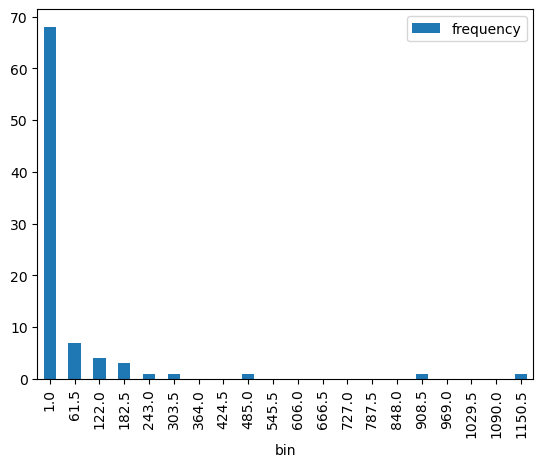

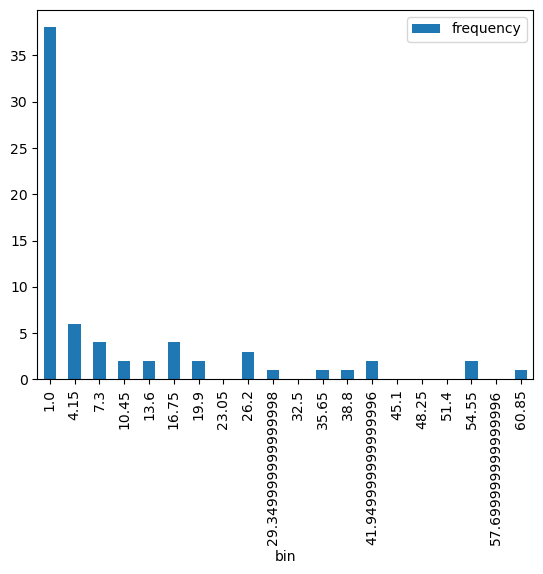

In [58]:
if show_parts:
    uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
    plot(uVal_df, "col1")
    plot(uVal_df.where("col1 < 65"), "col1")

In [59]:
if show_parts:
    print(uVal_df.count())
    print(uVal_df.where("col1 >= 30").count())
    print(uVal_df.where("col1 >= 50").count())
    print(uVal_df.where("col1 >= 100").count())

87
26
21
13


In [60]:
anime_df, col_list = oneHotEncoding(anime_df, "Licensors", show=show_parts, support=100)
anime_embed_columns['Licensors'] = col_list
if show_parts:
    anime_df.show()

Fill rate: 4735/24831


+--------------------+--------------------------+-------------------+---------------------+------------------------+---------------------+--------------------+------------------------------+------------------------+----------------------------+-------------------+----------------------------------+----------------------------+------------------------------+
|           Licensors|Licensors_Sentai Filmworks|Licensors_ADV Films|Licensors_Kitty Media|Licensors_Media Blasters|Licensors_Crunchyroll|Licensors_Funimation|Licensors_Bandai Entertainment|Licensors_Discotek Media|Licensors_Aniplex of America|Licensors_VIZ Media|Licensors_Geneon Entertainment USA|Licensors_Central Park Media|Licensors_Nozomi Entertainment|
+--------------------+--------------------------+-------------------+---------------------+------------------------+---------------------+--------------------+------------------------------+------------------------+----------------------------+-------------------+----------------

+--------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------

+--------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------

#### Studios (finished)

In [61]:
if show_parts:
    uVal = unique_categories(anime_df, "Studios", False)
    print(len(uVal))

1043


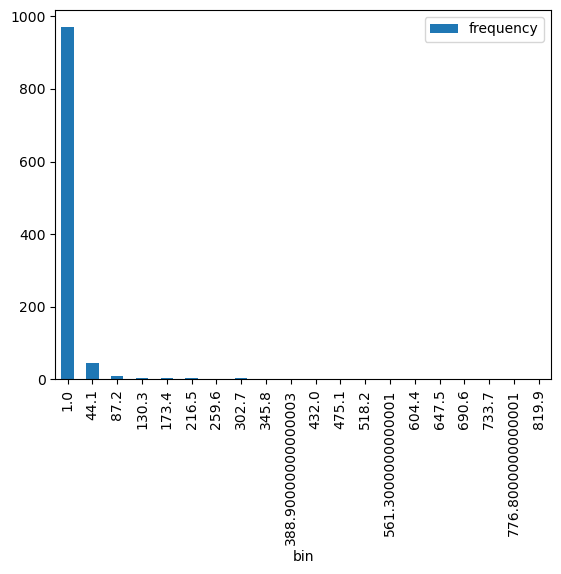

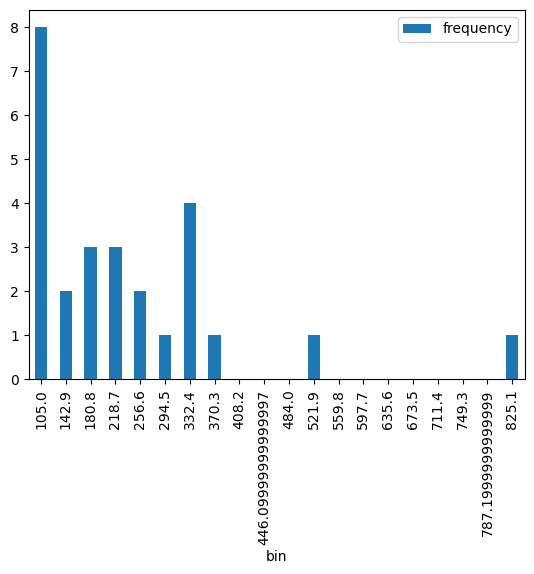

In [62]:
if show_parts:
    uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
    plot(uVal_df, "col1")
    plot(uVal_df.where("col1 > 100"), "col1")

In [63]:
if show_parts:
    print(uVal_df.count())
    print(uVal_df.where("col1 >= 100").count())
    print(uVal_df.where("col1 >= 150").count())

1043
26
18


In [64]:
anime_df, anime_embed_columns['Studios'] = oneHotEncoding(anime_df, "Studios", show=show_parts, support=100)
if show_parts:
    anime_df.show()

Fill rate: 14366/24831


+--------------------+-------------+-----------------+---------------+---------------+-----------+-------------+-------------+--------------------+----------------+----------------------+-------------------+------------------------+----------------------+-----------+-------------+-----------------+-------------------------+-------------------------+-----------+--------------------+------------+-----------------------+----------------------------+--------------------+-------------+--------------------------------------+
|             Studios|Studios_Bones|Studios_Satelight|Studios_Sunrise|Studios_Pierrot|Studios_AIC|Studios_Xebec|Studios_Gonzo|Studios_A-1 Pictures|Studios_Madhouse|Studios_Production I.G|Studios_Studio Deen|Studios_Nippon Animation|Studios_Toei Animation|Studios_OLM|Studios_Shaft|Studios_J.C.Staff|Studios_Shin-Ei Animation|Studios_TMS Entertainment|Studios_DLE|Studios_Brain's Base|Studios_Arms|Studios_Kyoto Animation|Studios_Tatsunoko Production|Studios_SILVER LINK.|Stud

+--------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+--------------------

+--------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+--------------------

#### Source (finished)

In [65]:
if show_parts:
    uVal = unique_categories(anime_df, "Source", False)
    print(len(uVal))

16


The number of categories is small, so we do not reduce.

In [66]:
anime_df, col_list = oneHotEncoding(anime_df, "Source", show=show_parts, support=100)
anime_embed_columns['Source'] = col_list
if show_parts:
    anime_df.show()

Fill rate: 21152/24831


+------------+---------------+-------------------+------------+----------------+------------+-----------+------------------+-----------+------------+-------------------+-------------------+------------------+------------+
|      Source|Source_Original|Source_Visual novel|Source_Manga|Source_Web manga|Source_Other|Source_Game|Source_Light novel|Source_Book|Source_Novel|Source_4-koma manga|Source_Picture book|Source_Mixed media|Source_Music|
+------------+---------------+-------------------+------------+----------------+------------+-----------+------------------+-----------+------------+-------------------+-------------------+------------------+------------+
|   Web novel|              0|                  0|           0|               0|           0|          0|                 0|          0|           0|                  0|                  0|                 0|           0|
|Visual novel|              0|                  1|           0|               0|           0|          0|       

+--------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+---------------------+-----------

+--------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+---------------------+-----------

#### Duration (finished)

The format is "? hr ? min (per ep)", we shall convert to a single number representing the duration for each episode in minutes.

In [67]:
import pandas as pd

temp_df = anime_df.select("Duration")
#temp_df.show()

data = temp_df.toPandas()["Duration"].tolist()
new_d = []
for i in range(len(data)):
    if data[i] is not None:
        S = data[i].split(" per ep")[0]
        if "min" not in S:
            if "hr" in S:
                S += " 0 min"
            else:
                S = "0 min " + S
        if "hr" not in S:
            S = "0 hr " + S
        if "sec" not in S:
            S += " 0 sec"
        
        h, m, s = S.split(" hr ")[0], S.split(" hr ")[1].split(" min ")[0], S.split(" hr ")[1].split(" min ")[1].split(" sec")[0]
        new_d.append(int(h)*3600+int(m)*60+int(s))
    else:
        new_d.append(None)
if show_parts:
    print(len(new_d))
data = spark.createDataFrame(pd.DataFrame({
    'Duration': data,
    'Duration_f': new_d
})).dropDuplicates()

anime_df = anime_df.join(data, 'Duration', 'left').drop("Duration").withColumnRenamed(existing="Duration_f", new="Duration").dropDuplicates()                   #p4stwi2x
if show_parts:
    anime_df.show()

24831


+--------+--------------------+-------+----------+---------+---------+-------+--------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+-------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+---------------------+------------------------+-

In [68]:
if show_parts:
    anime_df.count()

#### Rating (finished)

This feature shall be used to filter the recommendation list by user's age and/or filter options, hence it is not to be in the processing.

In [69]:
anime_df = anime_df.drop("Rating")

#### Rank (finished)

From the author: "The rank of the anime based on popularity or other criteria". Since the metric is not clear and we are here to predict the ranking by ourselves, so it is better to have this feature removed.

In [70]:
anime_df = anime_df.drop("Rank")

#### Popularity (finished)

From the author: "The popularity rank of the anime". It is indeed that the more popular titles are likely to be watched by users, so they should appear higher on our predicted ranking list.

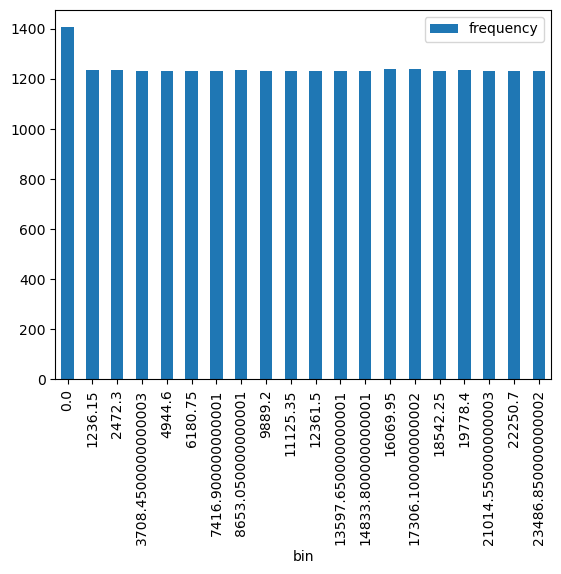

In [71]:
if show_parts:
    plot(anime_df, "Popularity")

However, it is indeed that this column is just the ranking for the titles, which do not have much value in determining the actual differences between the popularity of two different anime titles. So it is better for us to drop this and come up with a different way to get the popularity.

In [72]:
anime_df = anime_df.drop("Popularity")

#### Favorites, Scored By, Members (finished)

As we mentioned with the Popularity column, we shall find ways to represent an anime title's popularity. That is why we keep these 3 features, using log normalization.

In [73]:
for i in ['Favorites', 'Scored_By', 'Members']:
    anime_df = anime_df.withColumn(i+'_l', log10(col(i)+1.0))\
        .drop(i).withColumnRenamed(existing=i+'_l', new=i)             

This feature suggests the number of times an anime title is scored. As explained from the Popularity feature, this shall determine how popular a title is to be better on our ranking list.

#### Image URL (finished)

The feature has nothing to do with data processing, so the column is expected to be removed.

In [74]:
anime_df = anime_df.drop("Image URL")

### Final results

In [75]:
if show_parts:
    print("Before: " + str(start_X) + " " + str(start_Y))
    print("After: ", end = '')
    print_shape(anime_df)
    anime_df.show()

Before: 24905 24
After: 

24831 146


+--------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+-------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+---------------------+------------------------+----------------+--------------+------------------+-------------+-------------------------

### Saving data

Preprocessed data

In [76]:
anime_df.coalesce(1).write\
        .option("header", "true")\
        .option("sep", ",")\
        .mode("overwrite")\
        .csv(anime_dataset_output)

Embedded columns list

In [77]:
import json

with open('anime_embed_col.json', 'w') as fp:
    json.dump(anime_embed_columns, fp, indent=4)

## Main dataset

#### Optional: Read pre-prepped side datasets

Note: 
- Ctrl+A to choose all code lines.
- Ctrl+K then Ctrl+C to comment all lines selected.
- Ctrl+K then Ctrl+U to uncomment all lines selected.
- Change the csv paths ONLY.

In [78]:
anime_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv("anime_dataset_prep.csv")
user_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv("user_dataset_prep.csv")

#### Read main dataset

In [79]:
rating_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(unified_dataset_input)

rating_df.dropDuplicates()

if show_parts:
    start_X, start_Y = rating_df.count(), len(rating_df.columns)
    print_shape(rating_df)
    #main_df.show(20) #This takes a while so by default is commented out.

24325191 5


#### Columns: Username, Anime Title

Since we already have the two ID columns, we shall remove these string columns to make the dataset far lighter.

In [80]:
rating_df = rating_df.drop('Username', 'Anime Title')

if show_parts:
    print_shape(rating_df)

24325191 3


#### Datasets: Join

We perform joining the datasets into one unified dataset.

In [81]:
main_df = rating_df\
    .join(user_df, rating_df['user_id'] == user_df['Mal ID'])\
    .join(anime_df, rating_df['anime_id'] == anime_df['anime_id'])

main_df = main_df.drop(user_df['Mal ID'], anime_df['anime_id'])
if show_parts:
    print_shape(main_df)

23419469 156


#### User: Mean Score (finished)

As mentioned in the user dataset, Mean Score column shall be used with rating score in main dataset to get what users actually gets towards the anime titles.

In [82]:
from pyspark.sql.functions import col
main_df = main_df.withColumn('actual_rating', col('rating') - col('Mean Score'))\
    .drop('rating', 'Mean Score')\
    .withColumnRenamed('actual_rating', 'rating')

#### Dataset: avoid syntax problem

We firstly replace all spaces characters to underscore for convenience.

In [83]:
to_change = {}
column_order = list(main_df.columns)
for i in range(len(column_order)):
    if ' ' in column_order[i]:
        new_name = column_order[i].replace(' ', '_')

        to_change[column_order[i]] = new_name
        column_order[i] = new_name

main_df = main_df.withColumnsRenamed(to_change)

Then we remove any character not an underscore nor alpha-numeric.

In [84]:
import re
to_change = {}
for i in range(len(column_order)):
    new_name = re.sub("[!@#$%^&*().,']","", column_order[i]) 

    if new_name != column_order[i]:
        to_change[column_order[i]] = new_name
        column_order[i] = new_name

main_df = main_df.withColumnsRenamed(to_change)

In [85]:
main_df = main_df.select(column_order)
main_df.sort('user_id').show()

+-------+--------+-----------+-------------+-----------------+-------------------+-------------------+------------------+------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+-------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+-------

#### Saving columns

In [86]:
import json

with open('unified_embed_col.json', 'w') as fp:
    json.dump(dict({'unified_embed': list(main_df.columns)}), fp, indent=4)

#### Saving short version of data

Note: 
- Ctrl+A to choose all code lines.
- Ctrl+K then Ctrl+C to comment all lines selected.
- Ctrl+K then Ctrl+U to uncomment all lines selected.

In [87]:
# temp_df = main_df.limit(10000)
# temp_df.coalesce(1).write\
#         .option("header", "true")\
#         .option("sep", ",")\
#         .mode("overwrite")\
#         .csv(unified_dataset_output)

#### Saving full data (very, very long > 8 mins)

Note: 
- Ctrl+A to choose all code lines.
- Ctrl+K then Ctrl+C to comment all lines selected.
- Ctrl+K then Ctrl+U to uncomment all lines selected.

In [88]:
# main_df.coalesce(1).write\
#         .option("header", "true")\
#         .option("sep", ",")\
#         .mode("overwrite")\
#         .csv(unified_dataset_output)

## Ending process

In [89]:
if show_parts:
    print_shape(main_df)
    main_df.show()

23419469 155


+-------+--------+-----------+-------------+-----------------+--------+-------------------+-------------------+-------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+-------------------+------------------+----------------------+-----------------------+--------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+----------------

In [90]:
spark.stop()